In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

In [3]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [4]:
# !pip install plotly==5.24.1

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm

In [6]:
import json
from pathlib import Path


activations_dirs = [
    {"model": "Llama3-8b-Instruct", "prompt": "Instruct", "temperature": "high", "path": Path("../data/activations/common_claim/llama_3_8b_instruct/sampling_high_temp_with_activations__prompt_cc/binary__seed_42")},
    {"model": "Llama3-8b-Instruct", "prompt": "Pretrained", "temperature": "high", "path": Path("../data/activations/common_claim/llama_3_8b_instruct/sampling_high_temp_with_activations__prompt_cc/binary_pretrained__seed_42")},
    {"model": "Llama3-8b", "prompt": "Instruct", "temperature": "high", "path": Path("../data/activations/common_claim/llama_3_8b/sampling_high_temp_with_activations__prompt_cc/binary__seed_42")},
    {"model": "Llama3-8b", "prompt": "Pretrained", "temperature": "high", "path": Path("../data/activations/common_claim/llama_3_8b/sampling_high_temp_with_activations__prompt_cc/binary_pretrained__seed_42")},
    {"model": "Llama3-8b-Instruct", "prompt": "Instruct", "temperature": "low", "path": Path("../data/activations/common_claim/llama_3_8b_instruct/sampling_low_temp_with_activations__prompt_cc/binary__seed_42")},
    {"model": "Llama3-8b-Instruct", "prompt": "Pretrained", "temperature": "low", "path": Path("../data/activations/common_claim/llama_3_8b_instruct/sampling_low_temp_with_activations__prompt_cc/binary_pretrained__seed_42")},
    {"model": "Llama3-8b", "prompt": "Instruct", "temperature": "low", "path": Path("../data/activations/common_claim/llama_3_8b/sampling_low_temp_with_activations__prompt_cc/binary__seed_42")},
    {"model": "Llama3-8b", "prompt": "Pretrained", "temperature": "low", "path": Path("../data/activations/common_claim/llama_3_8b/sampling_low_temp_with_activations__prompt_cc/binary_pretrained__seed_42")},
]

models_answers = []

for activation_dir in activations_dirs:
    model_name = activation_dir["model"]
    answers_file = activation_dir["path"] / "answers.json"
    with answers_file.open("r") as f:
        models_answers.append({"model": activation_dir["model"], "prompt": activation_dir["prompt"], "temperature": activation_dir["temperature"], "answers": json.load(f), "path": activation_dir["path"]})


In [7]:
def extract_predictions_from_llm_answers(answers):
    for answer in answers:
        pred = answer["prediction"].lower().strip()
        if pred.startswith("true"):
            answer["llm_pred"] = "True"
        elif pred.startswith("false"):
            answer["llm_pred"] = "False"
        else:
            answer["llm_pred"] = "None"
    return answers

for data in models_answers:
    data["answers"] = extract_predictions_from_llm_answers(data["answers"])
for data in models_answers:
    data["labels"] = [a["gold"] for a in data["answers"]]
    data["preds"] = [a["llm_pred"] for a in data["answers"]]

In [8]:
import pandas as pd
from tabulate import tabulate

def create_latex_table_from_counts(models_answers):
    results = []
    for data in models_answers:
        unique, counts = np.unique(data["preds"], return_counts=True)
        counts_dict = dict(zip(unique, counts))
        true_count = counts_dict.get('True', 0)
        false_count = counts_dict.get('False', 0)
        none_count = counts_dict.get('None', 0)
        total = sum(counts_dict.values())
        results.append([
            data["model"],
            data["prompt"],
            data["temperature"],
            f"{true_count} ({true_count/total:.2%})",
            f"{false_count} ({false_count/total:.2%})",
            f"{none_count} ({none_count/total:.2%})",
            none_count,
        ])
    
    df = pd.DataFrame(results, columns=['Model', 'Prompt', 'Temperature', 'True', 'False', 'None', 'None Count'])
    df = df.sort_values(by="None Count", ascending=True).drop(columns=["None Count"])
    latex_table = tabulate(df, headers='keys', tablefmt='latex', showindex=False)
    return df, latex_table

df, latex_table = create_latex_table_from_counts(models_answers)
print("LaTeX Table:")
print(latex_table)

df

LaTeX Table:
\begin{tabular}{llllll}
\hline
 Model              & Prompt     & Temperature   & True          & False         & None          \\
\hline
 Llama3-8b-Instruct & Instruct   & high          & 2263 (50.85\%) & 2187 (49.15\%) & 0 (0.00\%)     \\
 Llama3-8b-Instruct & Instruct   & low           & 2276 (51.15\%) & 2174 (48.85\%) & 0 (0.00\%)     \\
 Llama3-8b          & Pretrained & low           & 3008 (67.60\%) & 1383 (31.08\%) & 59 (1.33\%)    \\
 Llama3-8b-Instruct & Pretrained & low           & 1814 (40.76\%) & 1887 (42.40\%) & 749 (16.83\%)  \\
 Llama3-8b          & Pretrained & high          & 1693 (38.04\%) & 1655 (37.19\%) & 1102 (24.76\%) \\
 Llama3-8b-Instruct & Pretrained & high          & 1551 (34.85\%) & 1406 (31.60\%) & 1493 (33.55\%) \\
 Llama3-8b          & Instruct   & high          & 897 (20.16\%)  & 951 (21.37\%)  & 2602 (58.47\%) \\
 Llama3-8b          & Instruct   & low           & 25 (0.56\%)    & 88 (1.98\%)    & 4337 (97.46\%) \\
\hline
\end{tabular}


,Model,Prompt,Temperature,True,False,None
0,Llama3-8b-Instruct,Instruct,high,2263 (50.85%),2187 (49.15%),0 (0.00%)
4,Llama3-8b-Instruct,Instruct,low,2276 (51.15%),2174 (48.85%),0 (0.00%)
7,Llama3-8b,Pretrained,low,3008 (67.60%),1383 (31.08%),59 (1.33%)
5,Llama3-8b-Instruct,Pretrained,low,1814 (40.76%),1887 (42.40%),749 (16.83%)
3,Llama3-8b,Pretrained,high,1693 (38.04%),1655 (37.19%),1102 (24.76%)
1,Llama3-8b-Instruct,Pretrained,high,1551 (34.85%),1406 (31.60%),1493 (33.55%)
2,Llama3-8b,Instruct,high,897 (20.16%),951 (21.37%),2602 (58.47%)
6,Llama3-8b,Instruct,low,25 (0.56%),88 (1.98%),4337 (97.46%)


In [9]:
import pandas as pd
from tabulate import tabulate

def create_latex_table(models_answers):
    results = []
    for data in models_answers:
        correct = sum(1 for a in data["answers"] if a['llm_pred'] == a['gold'])
        total = len(data["answers"])
        accuracy = correct / total
        results.append([data["model"], data["prompt"], data["temperature"], f"{correct}/{total}", f"{accuracy:.2%}"])
    
    df = pd.DataFrame(results, columns=['Model', 'Prompt', 'Temperature', 'Correct/Total', 'Accuracy'])
    df = df.sort_values(by="Accuracy", ascending=False)
    latex_table = tabulate(df, headers='keys', tablefmt='latex', showindex=False)
    return df, latex_table

df, latex_table = create_latex_table(models_answers)
print("LaTeX Table:")
print(latex_table)

df.sort_values(by="Accuracy", ascending=False)


LaTeX Table:
\begin{tabular}{lllll}
\hline
 Model              & Prompt     & Temperature   & Correct/Total   & Accuracy   \\
\hline
 Llama3-8b-Instruct & Instruct   & low           & 3343/4450       & 75.12\%     \\
 Llama3-8b-Instruct & Instruct   & high          & 3306/4450       & 74.29\%     \\
 Llama3-8b          & Pretrained & low           & 3069/4450       & 68.97\%     \\
 Llama3-8b-Instruct & Pretrained & low           & 2807/4450       & 63.08\%     \\
 Llama3-8b-Instruct & Pretrained & high          & 2219/4450       & 49.87\%     \\
 Llama3-8b          & Pretrained & high          & 1957/4450       & 43.98\%     \\
 Llama3-8b          & Instruct   & high          & 1059/4450       & 23.80\%     \\
 Llama3-8b          & Instruct   & low           & 85/4450         & 1.91\%      \\
\hline
\end{tabular}


,Model,Prompt,Temperature,Correct/Total,Accuracy
4,Llama3-8b-Instruct,Instruct,low,3343/4450,75.12%
0,Llama3-8b-Instruct,Instruct,high,3306/4450,74.29%
7,Llama3-8b,Pretrained,low,3069/4450,68.97%
5,Llama3-8b-Instruct,Pretrained,low,2807/4450,63.08%
1,Llama3-8b-Instruct,Pretrained,high,2219/4450,49.87%
3,Llama3-8b,Pretrained,high,1957/4450,43.98%
2,Llama3-8b,Instruct,high,1059/4450,23.80%
6,Llama3-8b,Instruct,low,85/4450,1.91%


# Linear probing on knowledge

In [10]:
from tqdm import tqdm
from hallucinations.features.hidden_states import load_hidden_state_features_from_shards, Features

model_hidden_states = []
features = Features(layer="all", hs_last_input_token=True, hs_last_generated_token=True)

for data in tqdm(models_answers):
    hidden_state_features = load_hidden_state_features_from_shards(data["path"] / "activations", features=features)
    hidden_state_features = {k: torch.stack(v).to(float).numpy() for k, v in hidden_state_features.items()}
    model_hidden_states.append({    
        "model": data["model"],
        "prompt": data["prompt"],
        "temperature": data["temperature"],
        "labels": data["labels"],
        "preds": [a["llm_pred"] for a in data["answers"]],
        "hidden_state_features": hidden_state_features,
    })

100%|██████████| 8/8 [03:43<00:00, 27.89s/it]


In [11]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def train_eval_classifier(hidden_states, labels, train_indices, test_indices, classifier_class, classifier_kwargs, scale=True, every_k_layers=2, pca_components=256):
    num_layers, dataset_size, embedding_dim = hidden_states.shape

    if scale:
        scaler = StandardScaler()

    if pca_components is not None:
        pca = PCA(n_components=pca_components)
    
    layer_preds = []
    layer_accuracies = []
    layer_f1s = []

    for layer in range(num_layers):
        if layer % every_k_layers != 0:
            continue

        X = hidden_states[layer]
        
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = labels[train_indices], labels[test_indices]

        clf = classifier_class(**classifier_kwargs)
        
        if scale:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
        if pca_components is not None:
            # Apply PCA
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)

        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)
        layer_preds.append(y_pred)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro")
        print(f"Layer {layer + 1}: Accuracy = {accuracy:.3f}, F1 score = {f1:.3f}")
        layer_accuracies.append(accuracy)
        layer_f1s.append(f1)

    return {"preds": layer_preds, "acc": layer_accuracies, "f1": layer_f1s}


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


linear_probe_results = []

for data in tqdm(model_hidden_states):
    print(data["model"], data["prompt"], data["temperature"])
    labels = np.array(data["labels"])
    dataset_size = len(data["labels"])
    train_indices, test_indices = train_test_split(np.arange(dataset_size), test_size=0.2, random_state=42, stratify=labels)

    for feature_type, hidden_features in data["hidden_state_features"].items():
        print(feature_type)
        classifier_class = LogisticRegression
        classifier_kwargs = {"max_iter": 500, "random_state": 42, "n_jobs": -1}
        linear_probe_results.append({
            "model": data["model"],
            "prompt": data["prompt"],
            "temperature": data["temperature"],
            "feature_type": feature_type,
            "linear_probe": train_eval_classifier(hidden_features, labels, train_indices, test_indices, classifier_class, classifier_kwargs, scale=True, every_k_layers=4, pca_components=256)
        })


  0%|          | 0/8 [00:00<?, ?it/s]

Llama3-8b-Instruct Instruct high
hs_last_input_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.500, F1 score = 0.333
Layer 5: Accuracy = 0.666, F1 score = 0.666
Layer 9: Accuracy = 0.709, F1 score = 0.709
Layer 13: Accuracy = 0.774, F1 score = 0.774
Layer 17: Accuracy = 0.785, F1 score = 0.785
Layer 21: Accuracy = 0.782, F1 score = 0.782
Layer 25: Accuracy = 0.787, F1 score = 0.786
Layer 29: Accuracy = 0.798, F1 score = 0.798
Layer 33: Accuracy = 0.800, F1 score = 0.800
hs_last_generated_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.500, F1 score = 0.333
Layer 5: Accuracy = 0.666, F1 score = 0.666
Layer 9: Accuracy = 0.709, F1 score = 0.709
Layer 13: Accuracy = 0.778, F1 score = 0.778
Layer 17: Accuracy = 0.787, F1 score = 0.787
Layer 21: Accuracy = 0.799, F1 score = 0.799
Layer 25: Accuracy = 0.802, F1 score = 0.802
Layer 29: Accuracy = 0.801, F1 score = 0.801


 12%|█▎        | 1/8 [09:04<1:03:28, 544.10s/it]

Layer 33: Accuracy = 0.792, F1 score = 0.792
Llama3-8b-Instruct Pretrained high
hs_last_input_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.500, F1 score = 0.333
Layer 5: Accuracy = 0.663, F1 score = 0.663
Layer 9: Accuracy = 0.716, F1 score = 0.716
Layer 13: Accuracy = 0.774, F1 score = 0.774
Layer 17: Accuracy = 0.792, F1 score = 0.792
Layer 21: Accuracy = 0.799, F1 score = 0.799
Layer 25: Accuracy = 0.811, F1 score = 0.811
Layer 29: Accuracy = 0.797, F1 score = 0.797
Layer 33: Accuracy = 0.796, F1 score = 0.795
hs_last_generated_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.500, F1 score = 0.333
Layer 5: Accuracy = 0.660, F1 score = 0.660
Layer 9: Accuracy = 0.725, F1 score = 0.725
Layer 13: Accuracy = 0.792, F1 score = 0.792
Layer 17: Accuracy = 0.796, F1 score = 0.795
Layer 21: Accuracy = 0.811, F1 score = 0.811
Layer 25: Accuracy = 0.807, F1 score = 0.807
Layer 29: Accuracy = 0.819, F1 score = 0.819


 25%|██▌       | 2/8 [15:12<44:05, 440.99s/it]  

Layer 33: Accuracy = 0.806, F1 score = 0.806
Llama3-8b Instruct high
hs_last_input_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.500, F1 score = 0.333
Layer 5: Accuracy = 0.680, F1 score = 0.680
Layer 9: Accuracy = 0.696, F1 score = 0.696
Layer 13: Accuracy = 0.739, F1 score = 0.739
Layer 17: Accuracy = 0.781, F1 score = 0.781


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Layer 21: Accuracy = 0.779, F1 score = 0.779


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Layer 25: Accuracy = 0.764, F1 score = 0.764
Layer 29: Accuracy = 0.771, F1 score = 0.771
Layer 33: Accuracy = 0.746, F1 score = 0.746
hs_last_generated_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.500, F1 score = 0.333
Layer 5: Accuracy = 0.679, F1 score = 0.678
Layer 9: Accuracy = 0.703, F1 score = 0.703
Layer 13: Accuracy = 0.734, F1 score = 0.734
Layer 17: Accuracy = 0.798, F1 score = 0.798
Layer 21: Accuracy = 0.782, F1 score = 0.782
Layer 25: Accuracy = 0.764, F1 score = 0.764
Layer 29: Accuracy = 0.764, F1 score = 0.764


 38%|███▊      | 3/8 [20:51<32:51, 394.40s/it]

Layer 33: Accuracy = 0.763, F1 score = 0.763
Llama3-8b Pretrained high
hs_last_input_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.500, F1 score = 0.333
Layer 5: Accuracy = 0.671, F1 score = 0.671
Layer 9: Accuracy = 0.712, F1 score = 0.712
Layer 13: Accuracy = 0.740, F1 score = 0.740
Layer 17: Accuracy = 0.791, F1 score = 0.791
Layer 21: Accuracy = 0.792, F1 score = 0.792
Layer 25: Accuracy = 0.772, F1 score = 0.772


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Layer 29: Accuracy = 0.789, F1 score = 0.789
Layer 33: Accuracy = 0.760, F1 score = 0.760
hs_last_generated_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.500, F1 score = 0.333
Layer 5: Accuracy = 0.661, F1 score = 0.661
Layer 9: Accuracy = 0.696, F1 score = 0.696
Layer 13: Accuracy = 0.765, F1 score = 0.765
Layer 17: Accuracy = 0.781, F1 score = 0.781
Layer 21: Accuracy = 0.783, F1 score = 0.783
Layer 25: Accuracy = 0.799, F1 score = 0.799
Layer 29: Accuracy = 0.781, F1 score = 0.781


 50%|█████     | 4/8 [24:21<21:25, 321.49s/it]

Layer 33: Accuracy = 0.773, F1 score = 0.773
Llama3-8b-Instruct Instruct low
hs_last_input_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.500, F1 score = 0.333
Layer 5: Accuracy = 0.669, F1 score = 0.669
Layer 9: Accuracy = 0.704, F1 score = 0.704
Layer 13: Accuracy = 0.773, F1 score = 0.773
Layer 17: Accuracy = 0.781, F1 score = 0.781
Layer 21: Accuracy = 0.784, F1 score = 0.784
Layer 25: Accuracy = 0.787, F1 score = 0.786
Layer 29: Accuracy = 0.790, F1 score = 0.790
Layer 33: Accuracy = 0.800, F1 score = 0.800
hs_last_generated_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.500, F1 score = 0.333
Layer 5: Accuracy = 0.667, F1 score = 0.667
Layer 9: Accuracy = 0.718, F1 score = 0.718
Layer 13: Accuracy = 0.781, F1 score = 0.781
Layer 17: Accuracy = 0.784, F1 score = 0.784
Layer 21: Accuracy = 0.797, F1 score = 0.797
Layer 25: Accuracy = 0.798, F1 score = 0.798
Layer 29: Accuracy = 0.797, F1 score = 0.797


 62%|██████▎   | 5/8 [26:57<13:05, 261.91s/it]

Layer 33: Accuracy = 0.792, F1 score = 0.792
Llama3-8b-Instruct Pretrained low
hs_last_input_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.500, F1 score = 0.333
Layer 5: Accuracy = 0.660, F1 score = 0.660
Layer 9: Accuracy = 0.720, F1 score = 0.720


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Layer 13: Accuracy = 0.783, F1 score = 0.783
Layer 17: Accuracy = 0.793, F1 score = 0.793
Layer 21: Accuracy = 0.798, F1 score = 0.798
Layer 25: Accuracy = 0.808, F1 score = 0.808
Layer 29: Accuracy = 0.793, F1 score = 0.793
Layer 33: Accuracy = 0.788, F1 score = 0.788
hs_last_generated_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.500, F1 score = 0.333


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Layer 5: Accuracy = 0.663, F1 score = 0.663
Layer 9: Accuracy = 0.720, F1 score = 0.720
Layer 13: Accuracy = 0.790, F1 score = 0.790
Layer 17: Accuracy = 0.799, F1 score = 0.799
Layer 21: Accuracy = 0.806, F1 score = 0.806
Layer 25: Accuracy = 0.806, F1 score = 0.806
Layer 29: Accuracy = 0.819, F1 score = 0.819


 75%|███████▌  | 6/8 [30:26<08:07, 243.96s/it]

Layer 33: Accuracy = 0.797, F1 score = 0.797
Llama3-8b Instruct low
hs_last_input_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.500, F1 score = 0.333
Layer 5: Accuracy = 0.669, F1 score = 0.669
Layer 9: Accuracy = 0.696, F1 score = 0.696
Layer 13: Accuracy = 0.740, F1 score = 0.740
Layer 17: Accuracy = 0.778, F1 score = 0.778
Layer 21: Accuracy = 0.781, F1 score = 0.781
Layer 25: Accuracy = 0.769, F1 score = 0.769
Layer 29: Accuracy = 0.774, F1 score = 0.774
Layer 33: Accuracy = 0.755, F1 score = 0.755
hs_last_generated_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.500, F1 score = 0.333
Layer 5: Accuracy = 0.688, F1 score = 0.688
Layer 9: Accuracy = 0.719, F1 score = 0.719
Layer 13: Accuracy = 0.735, F1 score = 0.735
Layer 17: Accuracy = 0.798, F1 score = 0.798
Layer 21: Accuracy = 0.782, F1 score = 0.782
Layer 25: Accuracy = 0.767, F1 score = 0.767
Layer 29: Accuracy = 0.772, F1 score = 0.772


 88%|████████▊ | 7/8 [33:05<03:36, 216.16s/it]

Layer 33: Accuracy = 0.755, F1 score = 0.755
Llama3-8b Pretrained low
hs_last_input_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.500, F1 score = 0.333
Layer 5: Accuracy = 0.665, F1 score = 0.665
Layer 9: Accuracy = 0.720, F1 score = 0.720
Layer 13: Accuracy = 0.743, F1 score = 0.743
Layer 17: Accuracy = 0.788, F1 score = 0.788
Layer 21: Accuracy = 0.785, F1 score = 0.785
Layer 25: Accuracy = 0.772, F1 score = 0.772
Layer 29: Accuracy = 0.791, F1 score = 0.791
Layer 33: Accuracy = 0.769, F1 score = 0.769
hs_last_generated_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.500, F1 score = 0.333
Layer 5: Accuracy = 0.648, F1 score = 0.648
Layer 9: Accuracy = 0.702, F1 score = 0.702
Layer 13: Accuracy = 0.765, F1 score = 0.765
Layer 17: Accuracy = 0.784, F1 score = 0.784
Layer 21: Accuracy = 0.782, F1 score = 0.782
Layer 25: Accuracy = 0.794, F1 score = 0.794
Layer 29: Accuracy = 0.780, F1 score = 0.780


100%|██████████| 8/8 [36:01<00:00, 270.19s/it]

Layer 33: Accuracy = 0.766, F1 score = 0.766


In [17]:
df_lr = pd.DataFrame(linear_probe_results)
df_lr["acc"] = df_lr["linear_probe"].apply(lambda x: x["acc"])


# fix the layers
df_lr = df_lr.explode("acc")
df_lr["layer"] = np.arange(0, 33, 4).tolist() * len(model_hidden_states) * 2

df_lr["feature_type"] = df_lr["feature_type"].map({"hs_last_input_token": "Last Input Tok", "hs_last_generated_token": "Last Gen. Tok"})
df_lr.head()


,model,prompt,temperature,feature_type,linear_probe,acc,layer
0,Llama3-8b-Instruct,Instruct,high,Last Input Tok,"{'preds': [['False', 'False', 'False', 'False'...",0.5,0
0,Llama3-8b-Instruct,Instruct,high,Last Input Tok,"{'preds': [['False', 'False', 'False', 'False'...",0.666292,4
0,Llama3-8b-Instruct,Instruct,high,Last Input Tok,"{'preds': [['False', 'False', 'False', 'False'...",0.708989,8
0,Llama3-8b-Instruct,Instruct,high,Last Input Tok,"{'preds': [['False', 'False', 'False', 'False'...",0.774157,12
0,Llama3-8b-Instruct,Instruct,high,Last Input Tok,"{'preds': [['False', 'False', 'False', 'False'...",0.785393,16


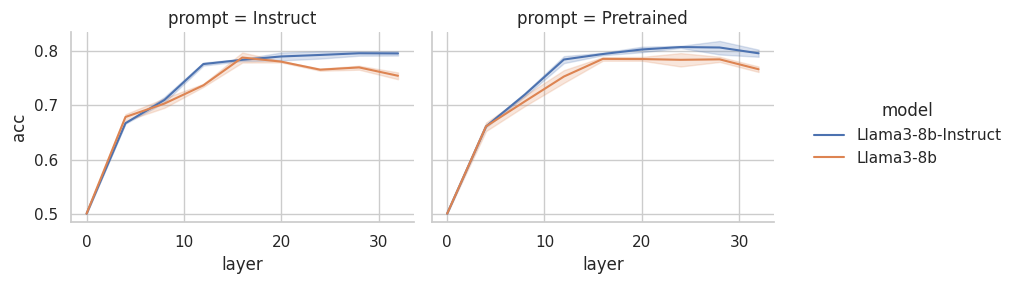

In [24]:
sns.set_theme(style="whitegrid")

g = sns.relplot(data=df_lr, x="layer", y="acc", col="prompt", hue="model", kind="line", markers=True, dashes=True, height=3)
g._legend.set_bbox_to_anchor((1, 0.5))
g._legend.set_loc('center left')
g._legend.set_frame_on(False)
plt.tight_layout()

# Linear probing on hallucinations

In [11]:
model_hidden_states[0].keys()

dict_keys(['model', 'prompt', 'temperature', 'labels', 'preds', 'hidden_state_features'])

In [12]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def train_eval_classifier(hidden_states, labels, train_indices, test_indices, classifier_class, classifier_kwargs, scale=True, every_k_layers=2, pca_components=256):
    num_layers, dataset_size, embedding_dim = hidden_states.shape

    if scale:
        scaler = StandardScaler()

    if pca_components is not None:
        pca = PCA(n_components=pca_components)
    
    layer_preds = []
    layer_accuracies = []
    layer_f1s = []
    layer_aucs = []

    for layer in range(num_layers):
        if layer % every_k_layers != 0:
            continue

        X = hidden_states[layer]
        
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = labels[train_indices], labels[test_indices]

        clf = classifier_class(**classifier_kwargs)
        
        if scale:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
        if pca_components is not None:
            # Apply PCA
            X_train = pca.fit_transform(X_train)
            X_test = pca.transform(X_test)

        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)[:, 1]
        layer_preds.append(y_pred)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro")
        auc = roc_auc_score(y_test, y_proba)
        print(f"Layer {layer + 1}: Accuracy = {accuracy:.3f}, F1 score = {f1:.3f}, AUC = {auc:.3f}")

        layer_accuracies.append(accuracy)
        layer_f1s.append(f1)
        layer_aucs.append(auc)

    return {"preds": layer_preds, "acc": layer_accuracies, "f1": layer_f1s, "auc": layer_aucs}


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


hallucination_results = []

for data in tqdm(model_hidden_states):
    print(data["model"], data["prompt"], data["temperature"])
    labels = np.array([0 if pred == ans else 1 for pred, ans in zip(data["preds"], data["labels"])])
    dataset_size = len(labels)
    train_indices, test_indices = train_test_split(np.arange(dataset_size), test_size=0.2, random_state=42, stratify=labels)

    for feature_type, hidden_features in data["hidden_state_features"].items():
        print(feature_type)
        classifier_class = LogisticRegression
        classifier_kwargs = {"max_iter": 500, "random_state": 42, "n_jobs": -1}
        hallucination_results.append({
            "model": data["model"],
            "prompt": data["prompt"],
            "temperature": data["temperature"],
            "feature_type": feature_type,
            "hallucination_rate": np.mean(labels),
            "linear_probe": train_eval_classifier(hidden_features, labels, train_indices, test_indices, classifier_class, classifier_kwargs, scale=True, every_k_layers=4, pca_components=256)
        })


  0%|          | 0/8 [00:00<?, ?it/s]

Llama3-8b-Instruct Instruct high
hs_last_input_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.743, F1 score = 0.426, AUC = 0.500
Layer 5: Accuracy = 0.728, F1 score = 0.493, AUC = 0.578
Layer 9: Accuracy = 0.719, F1 score = 0.491, AUC = 0.591
Layer 13: Accuracy = 0.721, F1 score = 0.508, AUC = 0.616
Layer 17: Accuracy = 0.728, F1 score = 0.598, AUC = 0.721
Layer 21: Accuracy = 0.736, F1 score = 0.611, AUC = 0.720
Layer 25: Accuracy = 0.740, F1 score = 0.619, AUC = 0.736
Layer 29: Accuracy = 0.736, F1 score = 0.618, AUC = 0.747
Layer 33: Accuracy = 0.737, F1 score = 0.612, AUC = 0.760
hs_last_generated_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.743, F1 score = 0.426, AUC = 0.500
Layer 5: Accuracy = 0.718, F1 score = 0.493, AUC = 0.536
Layer 9: Accuracy = 0.720, F1 score = 0.477, AUC = 0.575
Layer 13: Accuracy = 0.712, F1 score = 0.519, AUC = 0.610
Layer 17: Accuracy = 0.719, F1 score = 0.595, AUC = 0.736
Layer 21: Accuracy = 0.724, F1 score = 0.603, AUC = 0.741
Layer 25: Accuracy = 0.736, F1 score = 0.622, AUC = 0.757
Layer 29: Accuracy = 0.737, F1 score = 0.627, AUC = 0.756


 12%|█▎        | 1/8 [05:32<38:49, 332.74s/it]

Layer 33: Accuracy = 0.738, F1 score = 0.612, AUC = 0.759
Llama3-8b-Instruct Pretrained high
hs_last_input_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.501, F1 score = 0.334, AUC = 0.500
Layer 5: Accuracy = 0.547, F1 score = 0.546, AUC = 0.567
Layer 9: Accuracy = 0.546, F1 score = 0.546, AUC = 0.568
Layer 13: Accuracy = 0.565, F1 score = 0.565, AUC = 0.592
Layer 17: Accuracy = 0.636, F1 score = 0.634, AUC = 0.671
Layer 21: Accuracy = 0.643, F1 score = 0.642, AUC = 0.672
Layer 25: Accuracy = 0.634, F1 score = 0.633, AUC = 0.682
Layer 29: Accuracy = 0.640, F1 score = 0.640, AUC = 0.682
Layer 33: Accuracy = 0.635, F1 score = 0.634, AUC = 0.685
hs_last_generated_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.501, F1 score = 0.334, AUC = 0.500
Layer 5: Accuracy = 0.558, F1 score = 0.558, AUC = 0.585
Layer 9: Accuracy = 0.563, F1 score = 0.563, AUC = 0.599
Layer 13: Accuracy = 0.560, F1 score = 0.559, AUC = 0.588
Layer 17: Accuracy = 0.635, F1 score = 0.634, AUC = 0.674
Layer 21: Accuracy = 0.638, F1 score = 0.638, AUC = 0.674
Layer 25: Accuracy = 0.648, F1 score = 0.648, AUC = 0.694
Layer 29: Accuracy = 0.661, F1 score = 0.661, AUC = 0.700


 25%|██▌       | 2/8 [08:58<25:49, 258.17s/it]

Layer 33: Accuracy = 0.648, F1 score = 0.648, AUC = 0.700
Llama3-8b Instruct high
hs_last_input_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.762, F1 score = 0.432, AUC = 0.500
Layer 5: Accuracy = 0.751, F1 score = 0.473, AUC = 0.542
Layer 9: Accuracy = 0.751, F1 score = 0.458, AUC = 0.560
Layer 13: Accuracy = 0.744, F1 score = 0.455, AUC = 0.555
Layer 17: Accuracy = 0.748, F1 score = 0.449, AUC = 0.493
Layer 21: Accuracy = 0.745, F1 score = 0.451, AUC = 0.496
Layer 25: Accuracy = 0.747, F1 score = 0.460, AUC = 0.493
Layer 29: Accuracy = 0.746, F1 score = 0.456, AUC = 0.473
Layer 33: Accuracy = 0.744, F1 score = 0.462, AUC = 0.519
hs_last_generated_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.762, F1 score = 0.432, AUC = 0.500
Layer 5: Accuracy = 0.751, F1 score = 0.473, AUC = 0.550
Layer 9: Accuracy = 0.744, F1 score = 0.451, AUC = 0.527
Layer 13: Accuracy = 0.747, F1 score = 0.444, AUC = 0.538
Layer 17: Accuracy = 0.745, F1 score = 0.470, AUC = 0.514
Layer 21: Accuracy = 0.742, F1 score = 0.454, AUC = 0.486
Layer 25: Accuracy = 0.753, F1 score = 0.474, AUC = 0.508
Layer 29: Accuracy = 0.735, F1 score = 0.458, AUC = 0.531


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 38%|███▊      | 3/8 [12:31<19:47, 237.59s/it]

Layer 33: Accuracy = 0.742, F1 score = 0.468, AUC = 0.517
Llama3-8b Pretrained high
hs_last_input_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.561, F1 score = 0.359, AUC = 0.500
Layer 5: Accuracy = 0.544, F1 score = 0.516, AUC = 0.534


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Layer 9: Accuracy = 0.530, F1 score = 0.504, AUC = 0.505
Layer 13: Accuracy = 0.499, F1 score = 0.473, AUC = 0.484
Layer 17: Accuracy = 0.539, F1 score = 0.518, AUC = 0.536
Layer 21: Accuracy = 0.539, F1 score = 0.517, AUC = 0.537
Layer 25: Accuracy = 0.551, F1 score = 0.528, AUC = 0.547
Layer 29: Accuracy = 0.574, F1 score = 0.542, AUC = 0.544
Layer 33: Accuracy = 0.547, F1 score = 0.521, AUC = 0.556
hs_last_generated_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.561, F1 score = 0.359, AUC = 0.500
Layer 5: Accuracy = 0.510, F1 score = 0.474, AUC = 0.489
Layer 9: Accuracy = 0.507, F1 score = 0.477, AUC = 0.496
Layer 13: Accuracy = 0.521, F1 score = 0.501, AUC = 0.501
Layer 17: Accuracy = 0.549, F1 score = 0.530, AUC = 0.539
Layer 21: Accuracy = 0.539, F1 score = 0.514, AUC = 0.530
Layer 25: Accuracy = 0.549, F1 score = 0.527, AUC = 0.538
Layer 29: Accuracy = 0.535, F1 score = 0.507, AUC = 0.544


 50%|█████     | 4/8 [15:46<14:43, 220.75s/it]

Layer 33: Accuracy = 0.551, F1 score = 0.518, AUC = 0.560
Llama3-8b-Instruct Instruct low
hs_last_input_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.752, F1 score = 0.429, AUC = 0.500
Layer 5: Accuracy = 0.733, F1 score = 0.480, AUC = 0.567


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Layer 9: Accuracy = 0.736, F1 score = 0.492, AUC = 0.568
Layer 13: Accuracy = 0.742, F1 score = 0.513, AUC = 0.629
Layer 17: Accuracy = 0.760, F1 score = 0.613, AUC = 0.758
Layer 21: Accuracy = 0.753, F1 score = 0.602, AUC = 0.748
Layer 25: Accuracy = 0.757, F1 score = 0.594, AUC = 0.758
Layer 29: Accuracy = 0.758, F1 score = 0.599, AUC = 0.751
Layer 33: Accuracy = 0.752, F1 score = 0.588, AUC = 0.749
hs_last_generated_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.752, F1 score = 0.429, AUC = 0.500
Layer 5: Accuracy = 0.740, F1 score = 0.503, AUC = 0.576
Layer 9: Accuracy = 0.743, F1 score = 0.502, AUC = 0.586
Layer 13: Accuracy = 0.736, F1 score = 0.509, AUC = 0.648
Layer 17: Accuracy = 0.757, F1 score = 0.611, AUC = 0.773
Layer 21: Accuracy = 0.772, F1 score = 0.637, AUC = 0.786
Layer 25: Accuracy = 0.773, F1 score = 0.647, AUC = 0.782
Layer 29: Accuracy = 0.785, F1 score = 0.665, AUC = 0.796


 62%|██████▎   | 5/8 [19:58<11:35, 231.90s/it]

Layer 33: Accuracy = 0.763, F1 score = 0.629, AUC = 0.791
Llama3-8b-Instruct Pretrained low
hs_last_input_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.630, F1 score = 0.387, AUC = 0.500
Layer 5: Accuracy = 0.618, F1 score = 0.550, AUC = 0.615
Layer 9: Accuracy = 0.628, F1 score = 0.561, AUC = 0.625
Layer 13: Accuracy = 0.648, F1 score = 0.587, AUC = 0.632
Layer 17: Accuracy = 0.679, F1 score = 0.651, AUC = 0.732
Layer 21: Accuracy = 0.694, F1 score = 0.664, AUC = 0.757
Layer 25: Accuracy = 0.712, F1 score = 0.684, AUC = 0.764
Layer 29: Accuracy = 0.709, F1 score = 0.682, AUC = 0.774
Layer 33: Accuracy = 0.728, F1 score = 0.701, AUC = 0.779
hs_last_generated_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.630, F1 score = 0.387, AUC = 0.500
Layer 5: Accuracy = 0.648, F1 score = 0.581, AUC = 0.607
Layer 9: Accuracy = 0.627, F1 score = 0.565, AUC = 0.626
Layer 13: Accuracy = 0.653, F1 score = 0.590, AUC = 0.654
Layer 17: Accuracy = 0.702, F1 score = 0.671, AUC = 0.747
Layer 21: Accuracy = 0.716, F1 score = 0.692, AUC = 0.767
Layer 25: Accuracy = 0.722, F1 score = 0.697, AUC = 0.773
Layer 29: Accuracy = 0.730, F1 score = 0.703, AUC = 0.780


 75%|███████▌  | 6/8 [23:37<07:35, 227.59s/it]

Layer 33: Accuracy = 0.724, F1 score = 0.695, AUC = 0.785
Llama3-8b Instruct low
hs_last_input_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.981, F1 score = 0.495, AUC = 0.500
Layer 5: Accuracy = 0.963, F1 score = 0.545, AUC = 0.785
Layer 9: Accuracy = 0.966, F1 score = 0.550, AUC = 0.815
Layer 13: Accuracy = 0.965, F1 score = 0.572, AUC = 0.842
Layer 17: Accuracy = 0.969, F1 score = 0.580, AUC = 0.846
Layer 21: Accuracy = 0.964, F1 score = 0.591, AUC = 0.800
Layer 25: Accuracy = 0.969, F1 score = 0.603, AUC = 0.765
Layer 29: Accuracy = 0.969, F1 score = 0.642, AUC = 0.779
Layer 33: Accuracy = 0.969, F1 score = 0.603, AUC = 0.839
hs_last_generated_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.981, F1 score = 0.495, AUC = 0.500
Layer 5: Accuracy = 0.958, F1 score = 0.596, AUC = 0.815
Layer 9: Accuracy = 0.963, F1 score = 0.519, AUC = 0.818
Layer 13: Accuracy = 0.972, F1 score = 0.590, AUC = 0.895
Layer 17: Accuracy = 0.963, F1 score = 0.545, AUC = 0.899
Layer 21: Accuracy = 0.972, F1 score = 0.636, AUC = 0.935
Layer 25: Accuracy = 0.970, F1 score = 0.607, AUC = 0.899
Layer 29: Accuracy = 0.980, F1 score = 0.695, AUC = 0.945


 88%|████████▊ | 7/8 [26:12<03:23, 203.93s/it]

Layer 33: Accuracy = 0.971, F1 score = 0.668, AUC = 0.910
Llama3-8b Pretrained low
hs_last_input_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.690, F1 score = 0.408, AUC = 0.500
Layer 5: Accuracy = 0.690, F1 score = 0.566, AUC = 0.595
Layer 9: Accuracy = 0.703, F1 score = 0.593, AUC = 0.651
Layer 13: Accuracy = 0.708, F1 score = 0.598, AUC = 0.654
Layer 17: Accuracy = 0.713, F1 score = 0.624, AUC = 0.735
Layer 21: Accuracy = 0.707, F1 score = 0.623, AUC = 0.737
Layer 25: Accuracy = 0.731, F1 score = 0.658, AUC = 0.743
Layer 29: Accuracy = 0.690, F1 score = 0.586, AUC = 0.706
Layer 33: Accuracy = 0.701, F1 score = 0.600, AUC = 0.681
hs_last_generated_token


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/sklearn/decomposition/_pca.py:794: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


Layer 1: Accuracy = 0.690, F1 score = 0.408, AUC = 0.500
Layer 5: Accuracy = 0.688, F1 score = 0.570, AUC = 0.595
Layer 9: Accuracy = 0.696, F1 score = 0.586, AUC = 0.640
Layer 13: Accuracy = 0.690, F1 score = 0.571, AUC = 0.638
Layer 17: Accuracy = 0.717, F1 score = 0.627, AUC = 0.737
Layer 21: Accuracy = 0.715, F1 score = 0.636, AUC = 0.747
Layer 25: Accuracy = 0.712, F1 score = 0.625, AUC = 0.746
Layer 29: Accuracy = 0.715, F1 score = 0.633, AUC = 0.746


/home/djaniak/mambaforge/envs/hallucinations/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 8/8 [30:27<00:00, 228.42s/it]

Layer 33: Accuracy = 0.715, F1 score = 0.633, AUC = 0.733


In [18]:
df_hal = pd.DataFrame(hallucination_results)
df_hal["f1"] = df_hal["linear_probe"].apply(lambda x: x["f1"])
df_hal["auc"] = df_hal["linear_probe"].apply(lambda x: x["auc"])

# fix the layers
df_hal = df_hal.explode(["f1", "auc"])
df_hal["layer"] = np.arange(0, 33, 4).tolist() * len(model_hidden_states) * 2

df_hal.head()


,model,prompt,temperature,feature_type,hallucination_rate,linear_probe,f1,auc,layer
0,Llama3-8b-Instruct,Instruct,high,hs_last_input_token,0.257079,"{'preds': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.426177,0.5,0
0,Llama3-8b-Instruct,Instruct,high,hs_last_input_token,0.257079,"{'preds': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.493061,0.578097,4
0,Llama3-8b-Instruct,Instruct,high,hs_last_input_token,0.257079,"{'preds': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.490711,0.591006,8
0,Llama3-8b-Instruct,Instruct,high,hs_last_input_token,0.257079,"{'preds': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.508094,0.616084,12
0,Llama3-8b-Instruct,Instruct,high,hs_last_input_token,0.257079,"{'preds': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",0.59822,0.720517,16


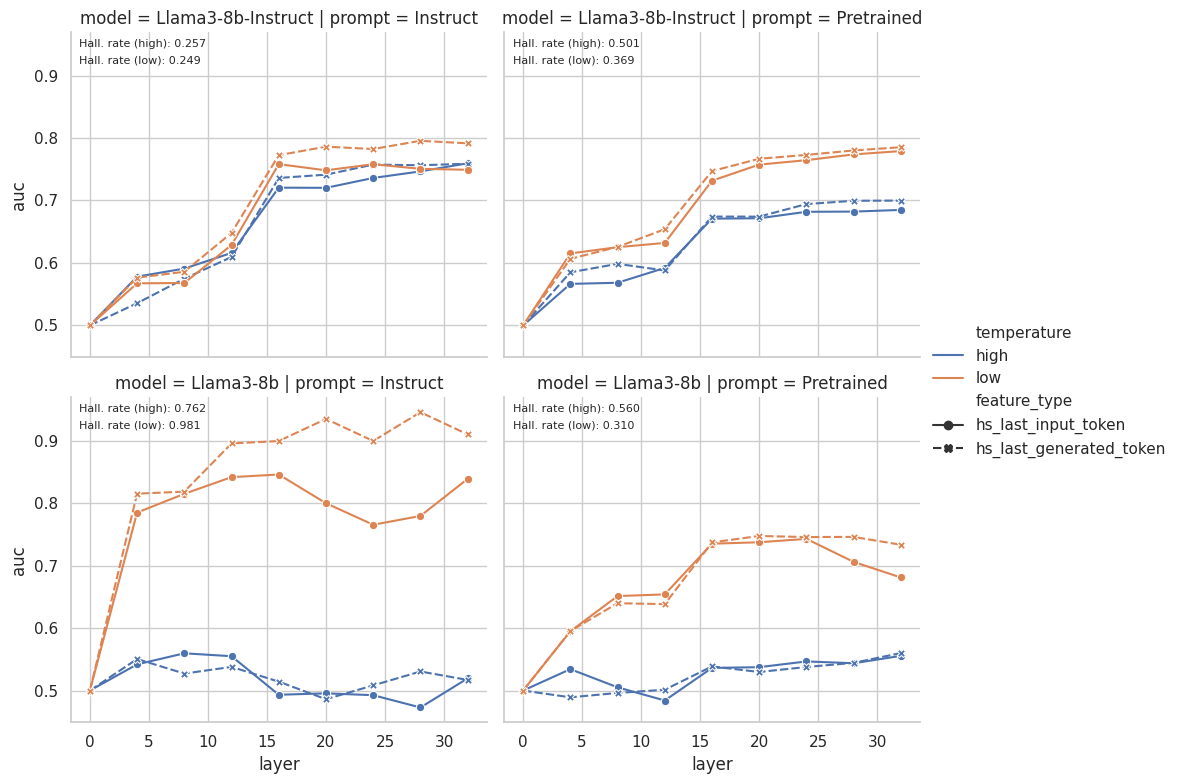

In [25]:
sns.set_theme(style="whitegrid")

g = sns.relplot(data=df_hal, x="layer", y="auc", row="model", col="prompt", 
                hue="temperature", style="feature_type", kind="line", 
                markers=True, dashes=True, aspect=1.2, height=4)

# Add hallucination rate as text annotation in each subplot
for row_idx, model in enumerate(df_hal['model'].unique()):
    for col_idx, prompt in enumerate(df_hal['prompt'].unique()):
        # Get unique temperatures and calculate vertical spacing
        temps = df_hal['temperature'].unique()
        spacing = 0.05  # Space between each line of text
        
        for i, temp in enumerate(temps):
            subset = df_hal[(df_hal['model'] == model) & 
                          (df_hal['prompt'] == prompt) & 
                          (df_hal['temperature'] == temp)]
            hal_rate = subset['hallucination_rate'].iloc[0]
            ax = g.axes[row_idx][col_idx]
            
            # Position text with proper vertical spacing
            y_pos = 0.98 - (i * spacing)
            ax.text(0.02, y_pos, 
                   f'Hall. rate ({temp}): {hal_rate:.3f}',
                   transform=ax.transAxes, 
                   fontsize=8,
                   verticalalignment='top')

plt.show()

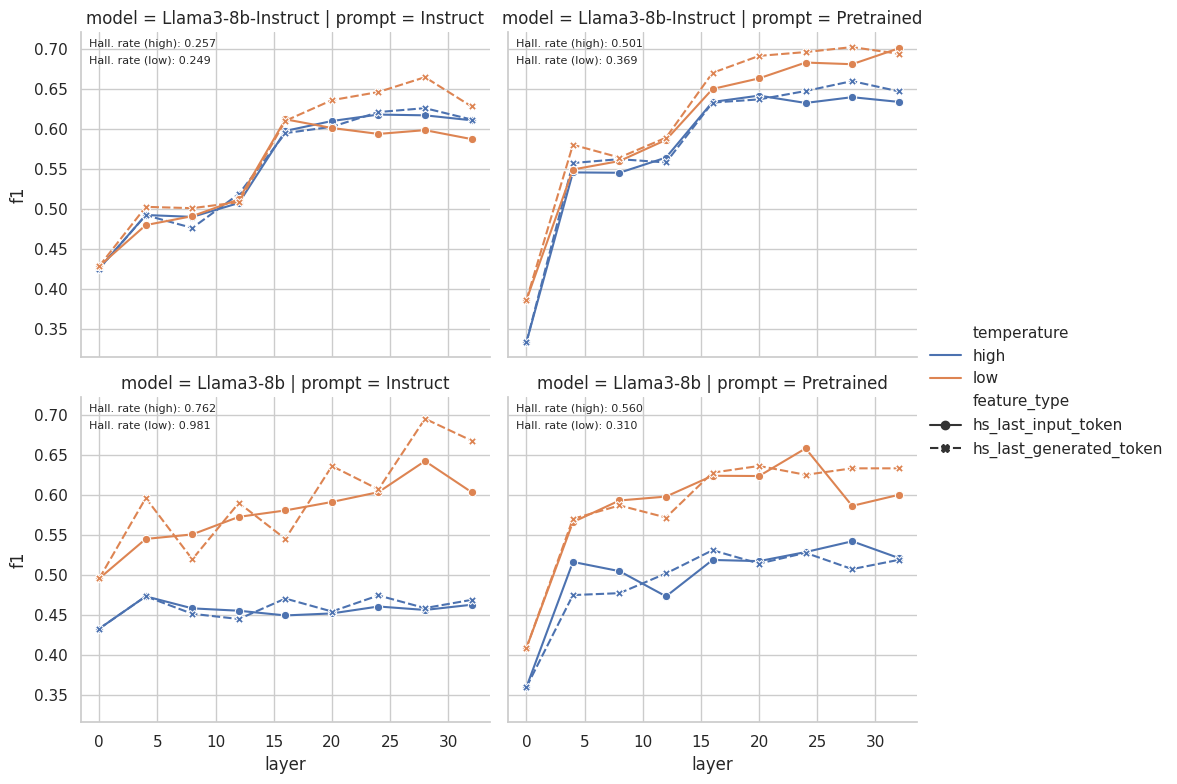

In [26]:
sns.set_theme(style="whitegrid")

g = sns.relplot(data=df_hal, x="layer", y="f1", row="model", col="prompt", 
                hue="temperature", style="feature_type", kind="line", 
                markers=True, dashes=True, aspect=1.2, height=4)

# Add hallucination rate as text annotation in each subplot
for row_idx, model in enumerate(df_hal['model'].unique()):
    for col_idx, prompt in enumerate(df_hal['prompt'].unique()):
        # Get unique temperatures and calculate vertical spacing
        temps = df_hal['temperature'].unique()
        spacing = 0.05  # Space between each line of text
        
        for i, temp in enumerate(temps):
            subset = df_hal[(df_hal['model'] == model) & 
                          (df_hal['prompt'] == prompt) & 
                          (df_hal['temperature'] == temp)]
            hal_rate = subset['hallucination_rate'].iloc[0]
            ax = g.axes[row_idx][col_idx]
            
            # Position text with proper vertical spacing
            y_pos = 0.98 - (i * spacing)
            ax.text(0.02, y_pos, 
                   f'Hall. rate ({temp}): {hal_rate:.3f}',
                   transform=ax.transAxes, 
                   fontsize=8,
                   verticalalignment='top')

plt.show()